# Task 2

You can load the Sydney housing dataset from https://www.kaggle.com/shree1992/housedata
where you can also find a description. The goal is to predict the ‘price’ column. For this
assignment you can ignore the date. Please don’t make any kernels public on Kaggle before
the assignment ends.

###  2.1
Determine which features are continuous vs categorical. Drop rows without a valid sales
price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


# to disregard warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
Sydney = pd.read_csv('data.csv')
#Sydney.head()

In [3]:
cont = list(Sydney.columns[Sydney.dtypes != object])
cate = list(Sydney.columns[Sydney.dtypes == object])

print("cont:", list(cont))
print("cat: ", list(cate))

# waterfront
print(Sydney.waterfront.value_counts())
print("")

#view
print(Sydney.view.value_counts())
print("")

#condition
print(Sydney.condition.value_counts())

cont: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
cat:  ['date', 'street', 'city', 'statezip', 'country']
0    4567
1      33
Name: waterfront, dtype: int64

0    4140
2     205
3     116
4      70
1      69
Name: view, dtype: int64

3    2875
4    1252
5     435
2      32
1       6
Name: condition, dtype: int64


Note: price is target

Since  waterfront values are only either 0 or 1, the feature should be regarded as categorical feature. Similar reasoning applies to columns view and condition where there are only few discrete values, as swhon above.

Thus, 

continuous features: 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built'

categorical features: 'date', 'street', 'city', 'statezip', 'country',  'waterfront', 'view', 'condition', 'yr_renovated'
       
**Note:** yr_renovated has nearly two big modes of whether renovated or not, as shown in distribution part(2) below. Thus, yr_renovated should also be classified as categorical feature.

In [4]:
#Preprocessing
new_df = Sydney.loc[Sydney.price != 0] # drop prices that are 0, which is unreasonable

# drop street since nearly most of data values are distinct
print(new_df.shape)
print(len(new_df.street.unique()))

# drop country since all houses are in US
print(Sydney.country.value_counts())

# only few dates
print(len(new_df.date.unique())) 

# drop unnecessary columns
new_df.drop(['street', 'country', 'date'], axis=1, inplace=True)

(4551, 18)
4476
USA    4600
Name: country, dtype: int64
70


Some of the columns do not seem to be much valulable in predicting house prices. For examles, since all the housing data are for housing in U.S., the country column is removed. Also, after removing the houses with price of 0, the data has now 4551 rows. However, the street column, as shown above, has 4551 discrete values, which means that the column is not much helpful. Moreover, date column got removed since there are not much variation in dates (i.e. only 70 different dates)


In [5]:
# change updated categorical types as objects
new_df[['waterfront', 'view', 'condition']] = new_df[['waterfront', 'view', 'condition']].astype(object)
# new_df.dtypes

###  2.2
Visualize the univariate distribution of each continuous feature, and the distribution of the
target. Do you notice anything? Is there something that might require special treatment?

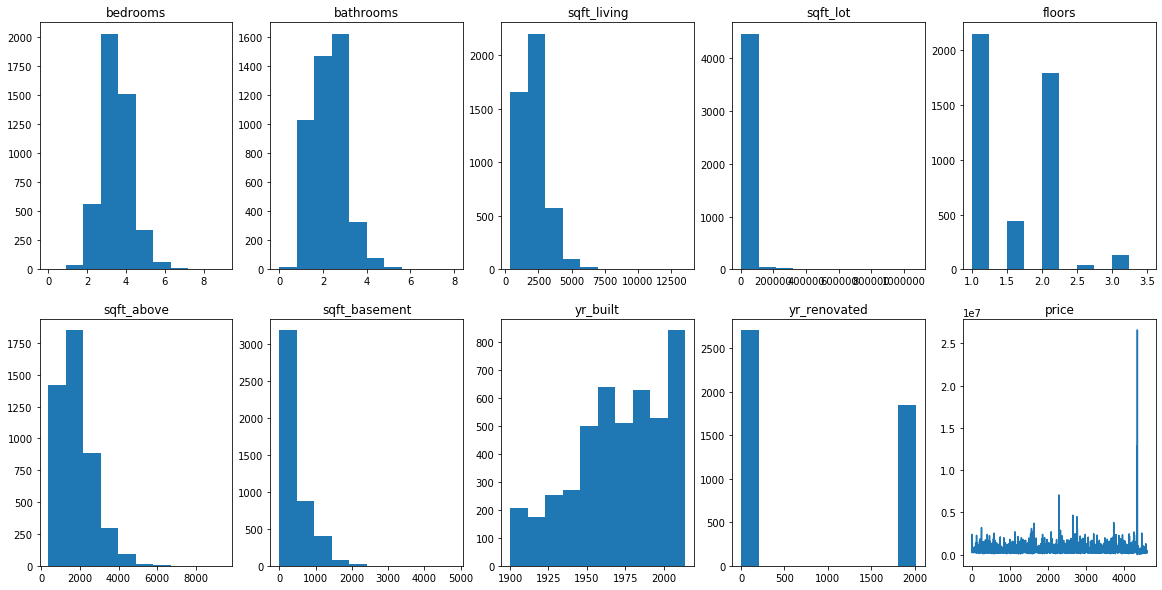

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
cont = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
i=0
j=0
for feat in list(cont):
    ax[i, j].hist(new_df[feat])
    ax[i, j].set_title(feat)
    if (j < 4):
        j += 1
    else:
        i +=1
        j =0

ax[1,4].plot(new_df.price)
ax[1,4].set_title("price");

In [7]:
print(Sydney.yr_renovated.value_counts().head())

new_df['yr_renovated'] = 1*(new_df.yr_renovated >0).astype(object)

0       2735
2000     170
2003     151
2001     109
2009     109
Name: yr_renovated, dtype: int64


Besides the waterfront, view, condition columns that are changed to consider as categorical features,
As shown above, there are are 2735 counts of yaer_renovated recored of 0. Then, this feature should rather be re-classified as either renovated or not renovated.


###  2.3
Visualize the dependency of the target on each continuous feature (2d scatter plot).


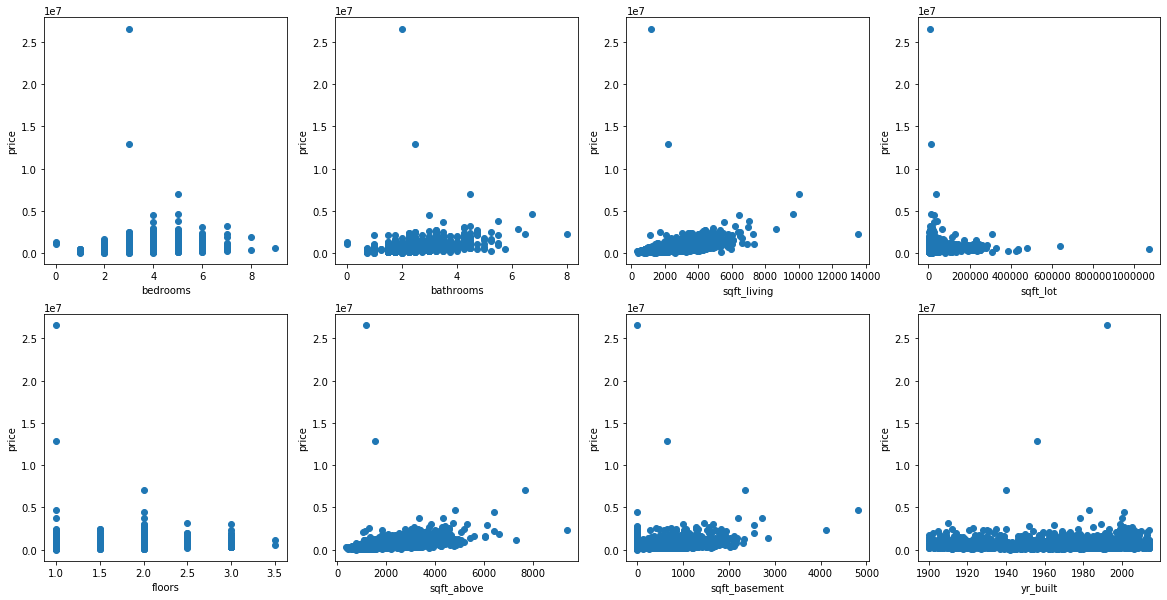

In [8]:
cont = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built']
fig, ax = plt.subplots(2, 4, figsize=(20,10))
           
i=0
j=0
for feat in list(cont):
    ax[i, j].scatter(new_df[feat], new_df.price)
    ax[i, j].set_xlabel(feat)
    ax[i, j].set_ylabel("price")
    if (j < 3):
        j += 1
    else:
        i +=1
        j =0

###  2.4
Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing
values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet
using cross-validation with the default parameters. Does scaling the data (within the pipeline)
with StandardScaler help? Use the preprocessing that works best going forward.

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector

In [10]:
y = new_df.price
X = new_df.drop(['price'], axis=1)

# train, test split  (no validation set used since it would only use cross_val_score)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 125)

categorical = X_train.dtypes == object

cat_preprocessing = make_pipeline( 
       SimpleImputer(strategy='constant', fill_value='NA'), 
       OneHotEncoder(handle_unknown='ignore'))

cont_preprocessing = make_pipeline(
      SimpleImputer())

preprocess = make_column_transformer(
(cat_preprocessing, make_column_selector(dtype_include='object')), 
    remainder=cont_preprocessing)

#pipeline
pipe_linR = make_pipeline(preprocess, LinearRegression())
pipe_ridge = make_pipeline(preprocess, Ridge())
pipe_lasso = make_pipeline(preprocess, Lasso())
pipe_eNet = make_pipeline(preprocess, ElasticNet())

linR_score = np.mean(cross_val_score(pipe_linR, X_train, y_train))
ridge_score = np.mean(cross_val_score(pipe_ridge, X_train, y_train))
lasso_score = np.mean(cross_val_score(pipe_lasso, X_train, y_train))
eNet_score = np.mean(cross_val_score(pipe_eNet, X_train, y_train))


#preprocess with scale
cont_preprocess_scale = make_pipeline(
      SimpleImputer(), StandardScaler())

preprocess_scale = make_column_transformer(
(cat_preprocessing, make_column_selector(dtype_include='object')), 
    remainder=cont_preprocess_scale)

pipe_linR = make_pipeline(preprocess_scale, LinearRegression())
pipe_ridge = make_pipeline(preprocess_scale, Ridge())
pipe_lasso = make_pipeline(preprocess_scale, Lasso())
pipe_eNet = make_pipeline(preprocess_scale, ElasticNet())

linR_score_scale = np.mean(cross_val_score(pipe_linR, X_train, y_train))
ridge_score_scale = np.mean(cross_val_score(pipe_ridge, X_train, y_train))
lasso_score_scale = np.mean(cross_val_score(pipe_lasso, X_train, y_train))
eNet_score_scale = np.mean(cross_val_score(pipe_eNet, X_train, y_train))


print("linear reg score without scale: ",linR_score, "\n"
      "ridge score without scale: ",ridge_score, "\n"
      "lasso score without scale: ",lasso_score, "\n"
      "eNet score without scale: ",eNet_score)
print("")
print("linear reg score with scale: ",linR_score_scale, "\n"
      "ridge score with scale: ",ridge_score_scale, "\n"
      "lasso score with scale: ",lasso_score_scale, "\n"
      "eNet score with scale: ",eNet_score_scale)



linear reg score without scale:  0.4716005478659497 
ridge score without scale:  0.3511695238719778 
lasso score without scale:  0.4718390861925533 
eNet score without scale:  0.3842449803610015

linear reg score with scale:  0.47175711987070823 
ridge score with scale:  0.4751765853050772 
lasso score with scale:  0.47183923987196286 
eNet score with scale:  0.3681886774875785


While there is no much difference between scores in linear regression and lasso, scaling with StandardScaler help especially for ridge model. However, for elastic net, the scaling actually decrease the model's score slightly 

###  2.5
Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize
the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.


In [11]:
param_grid_ridge = {'ridge__alpha': np.logspace(-3, 2, 6)}
param_grid_lasso = {'lasso__alpha': np.logspace(-3, 2, 6) }
param_grid_eNet = {'elasticnet__alpha': np.logspace(-3, 2, 6), 
             'elasticnet__l1_ratio': [0.01, .25, .50, .75, 1]}

grid_ridge = GridSearchCV(pipe_ridge, param_grid= param_grid_ridge, cv=5)
grid_ridge.fit(X_train, y_train)

grid_lasso = GridSearchCV(pipe_lasso, param_grid = param_grid_lasso, cv=5)
grid_lasso.fit(X_train, y_train)

grid_eNet = GridSearchCV(pipe_eNet, param_grid = param_grid_eNet, cv=5)
grid_eNet.fit(X_train, y_train)

print("lin reg test-set score: {:.3f}".format(grid_ridge.score(X_test, y_test)))
print("lasso test-set score: {:.3f}".format(grid_lasso.score(X_test, y_test)))
print("elastic net neighbor test-set score: {:.3f}".format(grid_eNet.score(X_test, y_test)))

lin reg test-set score: 0.738
lasso test-set score: 0.719
elastic net neighbor test-set score: 0.741


All of the three model's scores imrproved a lot

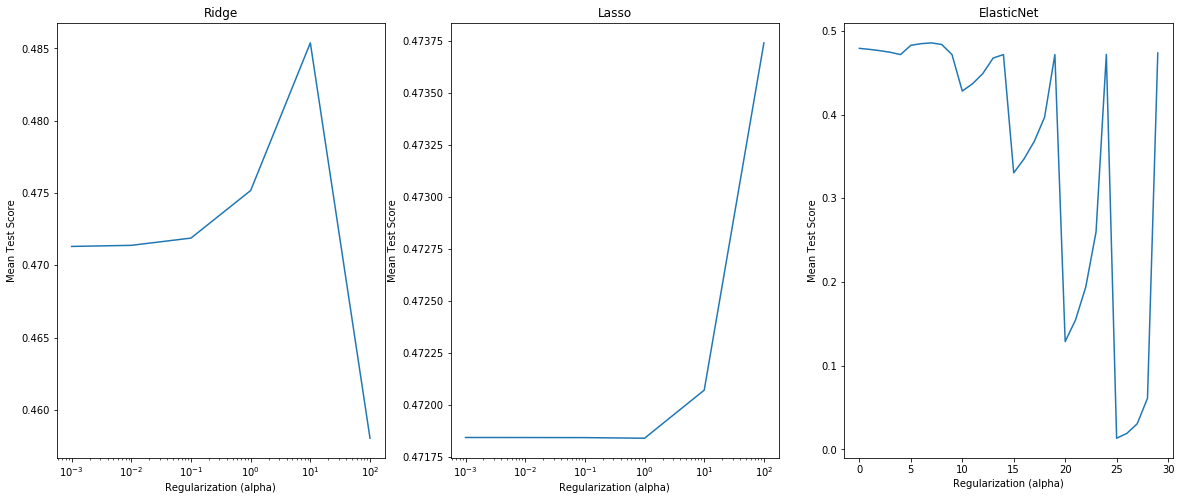

In [12]:
fig, ax = plt.subplots(1,3, figsize=(20, 8))
ax[0].plot( np.logspace(-3, 2, 6), grid_ridge.cv_results_['mean_test_score'])
ax[0].set_xlabel("Regularization (alpha)")
ax[0].set_ylabel("Mean Test Score")
ax[0].set_title("Ridge")
ax[0].set_xscale('log')

ax[1].plot(np.logspace(-3, 2, 6), grid_lasso.cv_results_['mean_test_score'])
ax[1].set_xlabel("Regularization (alpha)")
ax[1].set_ylabel("Mean Test Score")
ax[1].set_title("Lasso")
ax[1].set_xscale('log')

ax[2].plot(grid_eNet.cv_results_['mean_test_score'])
ax[2].set_xlabel("Regularization (alpha)")
ax[2].set_ylabel("Mean Test Score")
ax[2].set_title("ElasticNet");

###  2.6
Visualize the 20 most important coefficients of the resulting models. Do they agree on which
features are important?

In [13]:
print("ridge best param", grid_ridge.best_params_)
print("lasso best param", grid_lasso.best_params_ )
print("elastic net param", grid_eNet.best_params_ )

ridge best param {'ridge__alpha': 10.0}
lasso best param {'lasso__alpha': 100.0}
elastic net param {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.5}


In [27]:
p_ridge = make_pipeline(preprocess_scale, Ridge(alpha = 10)) #i.e. best param
p_ridge.fit(X_train, y_train)

coeff_ridge = p_ridge['ridge'].coef_

onehotencoder = p_ridge.named_steps['columntransformer'].transformers[0][1][1]
#onehotencoder.fit(X_train, y_train).get_feature_names()